# organise_annotation

Organise landmark annotation result on Zeno's face images and prepare the data for further processing.

## Step 1: Import modules

In [6]:
import os
import sys
import glob
import dlib
import time
import random
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
try:
    from ConfigParser import ConfigParser    # If using Python 2.7
except ImportError:
    from configparser import ConfigParser    # If using Python 3.5
config = ConfigParser()
config.read('config.ini')
sys.path.append(os.path.realpath(config.get('facial_landmark_tracker', 'repository_path')))
import ibug_face_tracker
from zeno_face_tracker_helpers import *
print('All modules imported.')

All modules imported.


## Step 1: Extract annotation result from the FAD files

In [7]:
# Get the annotated batches
annotated_batches = [float(x) for x in config.get('data_organisation', 'annotated_batches').strip().replace(
    ' ', '').replace('\'', '').replace('\"', '').split(',') if len(x) > 0]
batch_paths = []
for batch_index in annotated_batches:
    batch_name = 'batch_%03d' % int(batch_index)
    batch_suffix = ('%.03f' % abs(batch_index - int(batch_index)))[1:]
    if batch_suffix != '.000':
        batch_path = os.path.realpath(os.path.join('./dataset', batch_name + batch_suffix + '.fad'))
    else:
        batch_path = os.path.realpath(os.path.join('./dataset', batch_name + '.fad'))
    if os.path.exists(batch_path):
        batch_paths.append(batch_path)
        print('Batch found: ' + batch_path)
    else:
        print('Batch not found: ' + batch_path)

# Extract annotation result
images_processed = 0
last_check_time = time.time()
for batch_path in batch_paths:
    annotations = load_annotation_job(batch_path, config.getint('data_organisation', 
                                                                'number_of_landmarks'))
    for annotation in annotations:
        image = cv2.imread(annotation['image_path'])
        pts_path = os.path.splitext(annotation['image_path'])[0] + '.annot.pts'
        save_pts(pts_path, annotation['facial_landmarks'])
        ibug_face_tracker.FaceTracker.plot_landmark_connections(image, annotation['facial_landmarks'])
        ibug_face_tracker.FaceTracker.plot_facial_landmarks(image, annotation['facial_landmarks'])
        cv2.imwrite(pts_path + '.png', image)
        images_processed += 1
        current_time = time.time()
        if last_check_time < current_time - 10.0:
            last_check_time = current_time
            print('Annotation of %d images have been extracted.' % images_processed)
print('Done, annotation of all %d images have been extracted.' % images_processed)

Batch found: C:\zeno_face_tracker\dataset\batch_000.fad
Done, annotation of all 85 images have been extracted.


## Step 2: Calculate mean shape from the annotation result

85 annotated landmark files loaded.
Mean shape has been saved to: C:\zeno_face_tracker\dataset\mean_shape.pts


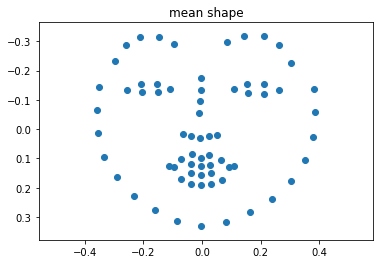

In [8]:
%matplotlib inline

# Load PTS files
annotations = []
recording_sessions = sorted(glob.glob(os.path.realpath(os.path.join('./dataset', 'cam*'))))
recording_sessions = [x for x in recording_sessions if os.path.isdir(x)]
for session_path in recording_sessions:
    session_name = os.path.basename(session_path)
    pts_files = sorted(glob.glob(os.path.join(session_path, '*.annot.pts')))
    for pts_file in pts_files:
        pts = load_pts(pts_file)
        index = int(os.path.basename(pts_file).split('.')[0])
        annotations.append({'session': session_name, 'index': index, 'landmarks': pts})
print('%d annotated landmark files loaded.' % len(annotations))

# Calculate mean shape
all_landmarks = np.zeros((len(annotations), 
                          annotations[0]['landmarks'].shape[0], 
                          annotations[0]['landmarks'].shape[1]))
for idx, annotation in enumerate(annotations):
    landmarks = annotation['landmarks'] - annotation['landmarks'].mean(axis=0)
    face_size = np.linalg.norm(landmarks.max(axis=0) - landmarks.min(axis=0))
    landmarks = landmarks / face_size
    all_landmarks[idx] = landmarks
mean_shape = all_landmarks.mean(axis=0)

# Save mean shape
mean_shape_path = os.path.realpath(os.path.join('./dataset', 'mean_shape.pts'))
save_pts(mean_shape_path, mean_shape)
print('Mean shape has been saved to: ' + mean_shape_path)

# Show the mean shape
plt.scatter(mean_shape[:, 0], mean_shape[:, 1])
plt.axes().set_aspect('equal', 'datalim')
plt.gca().invert_yaxis()
plt.title('mean shape')
plt.show()

## Step3: Align annotated landmarks to the mean shape

Done, 85 aligned landmark files saved.


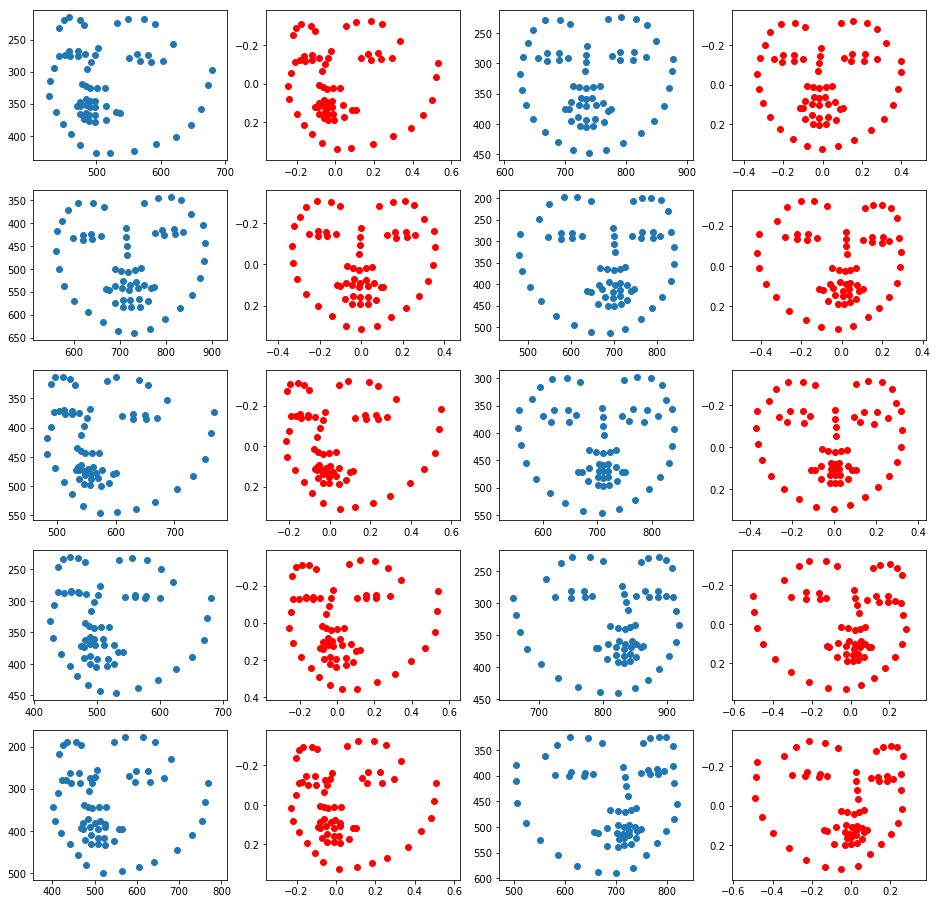

Shown above are the following randomly drawn examples (raw vs. aligned):
cam_m1/000084.annot.aligned.pts, cam_m2/000055.annot.aligned.pts
cam_h3/000081.annot.aligned.pts, cam_m3/000028.annot.aligned.pts
cam_h1/000083.annot.aligned.pts, cam_h1/000069.annot.aligned.pts
cam_m1/000049.annot.aligned.pts, cam_m2/000089.annot.aligned.pts
cam_m3/000079.annot.aligned.pts, cam_h4/000067.annot.aligned.pts


In [9]:
%matplotlib inline

# Align landmarks
anchors = [int(x) for x in config.get('data_organisation', 'alignment_anchors').strip().replace(
    ' ', '').replace('\'', '').replace('\"', '').split(',') if len(x) > 0]
for annotation in annotations:
    annotation['aligned_landmarks'], _ = align_landmarks(
        annotation['landmarks'], mean_shape, anchors)

# Save the aligned landmarks
for annotation in annotations:
    pts_path = os.path.realpath(os.path.join('./dataset', annotation['session'], 
                                             '%06d.annot.aligned.pts' % annotation['index']))
    save_pts(pts_path, annotation['aligned_landmarks'], 6)
print('Done, %d aligned landmark files saved.' % len(annotations))

# Randomly show 10 examples
examples_paths = []
matplotlib.rcParams['figure.figsize'] = [16, 16]
for idx, annotation in enumerate(random.sample(annotations, 10)):
    ax = plt.subplot(5, 4, idx * 2 + 1)
    plt.scatter(annotation['landmarks'][:, 0], annotation['landmarks'][:, 1])
    ax.set_aspect('equal', 'datalim')
    ax.invert_yaxis()
    ax = plt.subplot(5, 4, idx * 2 + 2)
    plt.scatter(annotation['aligned_landmarks'][:, 0], 
                annotation['aligned_landmarks'][:, 1], c='r')
    ax.set_aspect('equal', 'datalim')
    ax.invert_yaxis()
    if idx % 2 == 0:
        paired_example_path = '%s/%06d.annot.aligned.pts' % (annotation['session'], 
                                                             annotation['index'])
    else:
        paired_example_path += ', %s/%06d.annot.aligned.pts' % (annotation['session'], 
                                                                annotation['index'])
        examples_paths.append(paired_example_path)
plt.show()
print('Shown above are the following randomly drawn examples (raw vs. aligned):\n' + 
      '\n'.join(examples_paths))

## Step 4: Combine landmarks with motor positions and face box and then save the result

In [11]:
# Load motor position records
session_record_paths = sorted(glob.glob(os.path.realpath(
    os.path.join('./dataset', 'cam*.pkl'))))
session_records = {}
for session_record_path in session_record_paths:
    session_name = os.path.splitext(os.path.basename(session_record_path))[0]
    session_records[session_name] = pd.read_pickle(session_record_path)
    print('Parsed: ' + session_record_path)

# Save everything into a single data frame, also get face bounding box for completeness
last_check_time = time.time()
face_detector = dlib.get_frontal_face_detector()
face_detection_scale = config.getfloat('facial_landmark_tracker', 'face_detection_scale')
face_detection_scale = max(face_detection_scale, 1e-6)
for idx, annotation in enumerate(annotations):
    session_record = session_records[annotation['session']]
    entry = session_record.loc[session_record['index'] == annotation['index']]
    annotation['motor_position'] = entry['motor_position'].values[0]
    annotation['time'] = entry['time'].values[0]
    image_path = os.path.realpath(os.path.join('./dataset', 
                                               annotation['session'], 
                                               '%06d.png' % annotation['index']))
    grayscale_image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2GRAY)
    image_size = (grayscale_image.shape[1], grayscale_image.shape[0])
    target_size = (int(max(round(image_size[0] * face_detection_scale), 1)), 
                   int(max(round(image_size[1] * face_detection_scale), 1)))
    if target_size != image_size:
        grayscale_image = cv2.resize(grayscale_image, target_size)
    detected_faces = sorted(
        [dlib.rectangle(int(round(face_box.left() / face_detection_scale)), 
                        int(round(face_box.top() / face_detection_scale)), 
                        int(round(face_box.right() / face_detection_scale)), 
                        int(round(face_box.bottom() / face_detection_scale))) 
         for face_box in face_detector(grayscale_image)], 
        key=dlib.rectangle.area, reverse=True)
    if len(detected_faces) > 0:
        annotation['face_box'] = (detected_faces[0].left(), 
                                  detected_faces[0].top(), 
                                  detected_faces[0].width(), 
                                  detected_faces[0].height())
    else:
        annotation['face_box'] = None
        print('Face detection failed in: ' + image_path)
    current_time = time.time()
    if last_check_time < current_time - 10.0:
        last_check_time = current_time
        print('%d items have been processed.' % (idx + 1))
print('All %d items have been processed.' % len(annotations))
package_path = os.path.realpath(os.path.join('./dataset', 'annotations.pkl'))
pd.DataFrame(annotations).to_pickle(package_path)
print('Everything is saved to: ' + package_path)

Parsed: C:\zeno_face_tracker\dataset\cam_h1.pkl
Parsed: C:\zeno_face_tracker\dataset\cam_h2.pkl
Parsed: C:\zeno_face_tracker\dataset\cam_h3.pkl
Parsed: C:\zeno_face_tracker\dataset\cam_h4.pkl
Parsed: C:\zeno_face_tracker\dataset\cam_l1.pkl
Parsed: C:\zeno_face_tracker\dataset\cam_l2.pkl
Parsed: C:\zeno_face_tracker\dataset\cam_l3.pkl
Parsed: C:\zeno_face_tracker\dataset\cam_l4.pkl
Parsed: C:\zeno_face_tracker\dataset\cam_m1.pkl
Parsed: C:\zeno_face_tracker\dataset\cam_m2.pkl
Parsed: C:\zeno_face_tracker\dataset\cam_m3.pkl
Parsed: C:\zeno_face_tracker\dataset\cam_m4.pkl
All 85 items have been processed.
Everything is saved to: C:\zeno_face_tracker\dataset\annotations.pkl
